In [1]:
import pandas as pds
import numpy as np
import os
from matplotlib import pyplot as plt
import defs
import simu

In [12]:
name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)
DF = DF.drop(['name', 'family_name'], axis=1)

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
aaa = 5.5
bbb = 0.01
ccc = 0.08
ddd = 0.7

ate_on_DF = aaa * 2.5
DF['Y'] = - 10 + aaa*DF['treatment']*DF['X2'] + bbb*np.exp(DF['X4']) + ccc*DF['X3']*DF['X1'] + ddd*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

nbr_in_common = 100
nbr_iter = 800
approx_integral = 50
a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
montecarlo_size_for_coverage = 105

methods = {'jaro-winkler':defs.jaro_winkler_similarity, 'levenshtein':defs.levenshtein_similarity, 'strict':defs.strict_equality, 'large':defs.large_equality}

dict_params_legend = {
    "unmatch":identifiers.keys(), 
    "match":identifiers.keys(), 
    "sigma_square":[f"$\sigma^2$"], 
    "betas":[ r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r"$\beta_5$", r"$\beta_6$", r"$\beta_7$" ], 
    "sigma2_square":[r"$\sigma_2^2$"], 
    "mu2":[r"$\mu_2$"], 
    "atel":["atel"]}

dict_params_title = {
    "unmatch":"unmatch", 
    "match":"match", 
    "sigma_square":r"$\sigma^2$", 
    "betas":r"$\beta$",
    "sigma2_square":r"$\sigma_2^2$", 
    "mu2":r"$\mu_2$", 
    "atel":"atel"}

sizeA = 430
sizeB = 250
n_A = sizeA + nbr_in_common
n_B = sizeB + nbr_in_common

dict_coverage = {"mean":[], "bounds_tuple":[], "ate_common_records":[], "ate_mean":[]}


In [3]:
mean, bounds_tuple, ate_common_records, ate_mean = simu.test_func(DF, identifiers, aaa, methods, covariates, nbr_in_common, nbr_iter, approx_integral, a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi, montecarlo_size_for_coverage)

100%|██████████| 800/800 [01:46<00:00,  7.50it/s]


In [13]:
dict_coverage["mean"].append(mean)
dict_coverage["bounds_tuple"].append(bounds_tuple)
dict_coverage["ate_common_records"].append(ate_common_records)
dict_coverage["ate_mean"].append(ate_mean)

In [14]:
nbr_simulations = 1

Text(0.5, 1.0, '95% credible interval for the ATE')

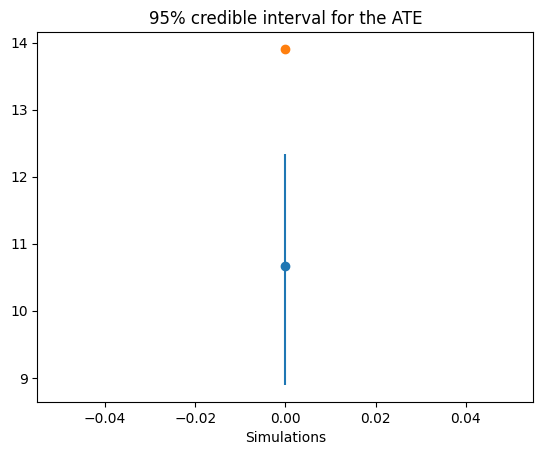

In [15]:
plt.errorbar(np.arange(nbr_simulations), dict_coverage["mean"], yerr=np.array(dict_coverage["bounds_tuple"]).T, fmt='o')
plt.plot(np.arange(nbr_simulations), dict_coverage["ate_common_records"], 'o')
plt.xlabel("Simulations")
plt.title("95% credible interval for the ATE")

Text(0.5, 1.0, '95% credible interval for the ATE centered around the ate_common_records')

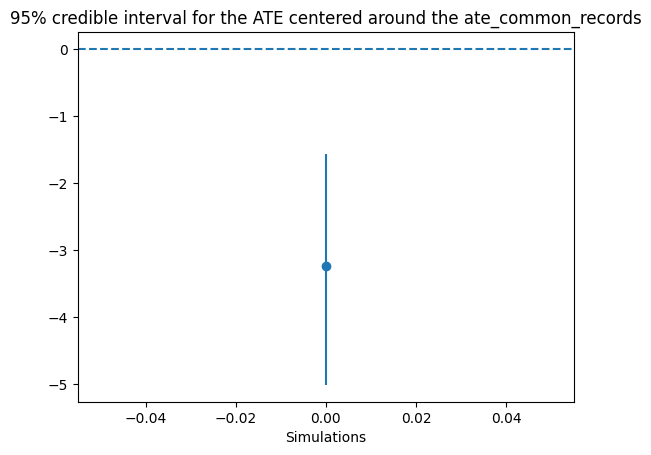

In [16]:
plt.errorbar(np.arange(nbr_simulations), dict_coverage["ate_mean"], yerr=np.array(dict_coverage["bounds_tuple"]).T, fmt='o')
plt.axhline(0, ls='--')
plt.xlabel("Simulations")
plt.title("95% credible interval for the ATE centered around the ate_common_records")